In [1]:
import pandas as pd
import numpy as np
import string, re

import pickle
pd.options.display.max_rows = 50

In [2]:
import nltk
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer ## TEST
from sklearn.feature_extraction.text import TfidfVectorizer ## TEST
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords ## TEST
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB

# nltk.download('stopwords') ##
# nltk.download('punkt') ##
# nltk.download('wordnet') ##

In [3]:
####CLEAN_DESCRIPTION - do I need this?
# df_clean_description = pd.read_csv('data/df_clean_description.csv')
# df_clean_description.head()


In [4]:
#Entire dataframe 
df = pd.read_csv('data/glassdoor_ratings_main.csv') 
df.head(3)

,SIZE,LOCATION_HQ,INDUSTRY,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,DESCRIPTION,MISSION,FULL_DESCRIPTION,DESC_LEN,RATING_DI_BIN,SIZE_BIN,HQ_STATE,TARGET
0,10000+ Employees,"New York, NY",Consulting,4.5,4.4,4.4,3.0,4.1,4.4,4.5,5198,We work with leaders across sectors to tackle ...,Mission: Our mission is two-fold: to help our ...,We work with leaders across sectors to tackle ...,1383,4,4.0,NY,1
1,10000+ Employees,"Ithaca, NY",Colleges & Universities,4.5,4.3,4.4,4.0,4.1,4.1,4.2,1765,"Cornell is a private, Ivy League university re...",,"Cornell is a private, Ivy League university re...",618,4,4.0,NY,1
2,5001 to 10000 Employees,"Santa Barbara, CA",Colleges & Universities,4.5,4.2,4.3,4.4,4.1,3.7,4.0,1049,"Dude, let's hit the beach! And then we'll hit ...",,"Dude, let's hit the beach! And then we'll hit ...",654,4,3.0,CA,1


## TESTING

### Preprocessing TEST

#### Tokenization

Tokenization is the process of splitting documents into units of observations. We usually represent the tokens as n-gram, where n represent the consecutive words occuring in a document. In the case of unigram (one word token), the sentence "David works here" can be tokenized into?

"David", "works", "here" "David works", "works here"

In [5]:
description = df.iloc[0, 12].lower()
description

'mission: our mission is two-fold: to help our clients make distinctive, lasting, and substantial improvements in their performance; and to build a firm that attracts, develops, excites, and retains exceptional people. these elements are strongly connected. helping clients solve their toughest problems requires the best people, and the best people are drawn to work that matters, together with supportive, dedicated colleagues.'

In [6]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

tokenized_description = tokenizer.tokenize(description)

In [7]:
fdist = FreqDist(tokenized_description)
print(fdist)

<FreqDist with 47 samples and 62 outcomes>


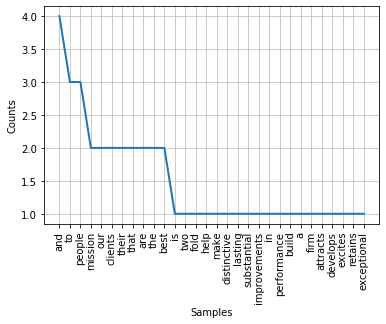

In [8]:
#should I remove capital letters?
plt.figure()
fdist.plot(30)

#### Stop Words

In [9]:
## automatic stop words, but you can add your own words as well
stop_words=set(stopwords.words("english")) 

In [10]:
filtered_description=[]
for w in tokenized_description:
    if w not in stop_words:
        filtered_description.append(w)
print("Filterd Sentence:",filtered_description)

Filterd Sentence: ['mission', 'mission', 'two', 'fold', 'help', 'clients', 'make', 'distinctive', 'lasting', 'substantial', 'improvements', 'performance', 'build', 'firm', 'attracts', 'develops', 'excites', 'retains', 'exceptional', 'people', 'elements', 'strongly', 'connected', 'helping', 'clients', 'solve', 'toughest', 'problems', 'requires', 'best', 'people', 'best', 'people', 'drawn', 'work', 'matters', 'together', 'supportive', 'dedicated', 'colleagues']


In [11]:
## After filtering words, words are now in half
print(len(tokenized_description))
print(len(filtered_description))

62
40


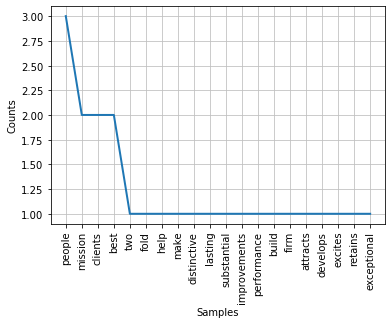

In [12]:
fdist = FreqDist(filtered_description)
plt.figure()
fdist.plot(20)

#### Stemming

In [13]:
from nltk.stem import PorterStemmer

In [14]:
filtered_description

['mission',
 'mission',
 'two',
 'fold',
 'help',
 'clients',
 'make',
 'distinctive',
 'lasting',
 'substantial',
 'improvements',
 'performance',
 'build',
 'firm',
 'attracts',
 'develops',
 'excites',
 'retains',
 'exceptional',
 'people',
 'elements',
 'strongly',
 'connected',
 'helping',
 'clients',
 'solve',
 'toughest',
 'problems',
 'requires',
 'best',
 'people',
 'best',
 'people',
 'drawn',
 'work',
 'matters',
 'together',
 'supportive',
 'dedicated',
 'colleagues']

In [15]:
ps = PorterStemmer()

stemmed_description=[]
for w in filtered_description:
    stemmed_description.append(ps.stem(w))

print(stemmed_description)

['mission', 'mission', 'two', 'fold', 'help', 'client', 'make', 'distinct', 'last', 'substanti', 'improv', 'perform', 'build', 'firm', 'attract', 'develop', 'excit', 'retain', 'except', 'peopl', 'element', 'strongli', 'connect', 'help', 'client', 'solv', 'toughest', 'problem', 'requir', 'best', 'peopl', 'best', 'peopl', 'drawn', 'work', 'matter', 'togeth', 'support', 'dedic', 'colleagu']


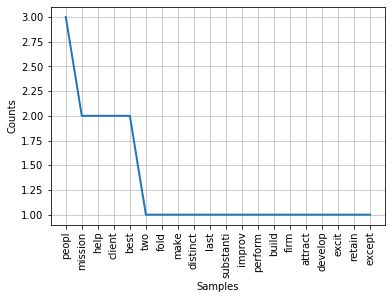

In [16]:
fdist = FreqDist(stemmed_description)
fdist.plot(20)

## WORKING

**Preprocessing**

In [17]:
### Same stopwords as in Cleaning notebook

## setting stopwords and punctuations
sw_list = stopwords.words('english')
sw_list += list(string.punctuation) #appending to stopwords
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '',
            '-', '—', '--', 'e.g', "'ll", "'ve", "'s",
            'company', 'services', 'world', 'people', 'care', 'health', 'us',
           ]
sw_set = set(sw_list) #list of stop words - why do I need to make it a set?

In [18]:
print(sw_set)

{'', 'hadn', 'm', 'about', '“', 'any', 'ours', 'from', 'which', 'so', '""', 'these', "aren't", "'ll", 'if', "doesn't", '>', 'health', 'most', 'few', ',', 'at', '‘', "shouldn't", 'our', 'but', 'not', "isn't", '%', "don't", '...', 'is', 'it', '`', 'were', 'too', 'o', 'did', 'mightn', 'should', 'where', 'through', 'what', 'in', 'd', '``', 'haven', 'below', 're', 'hasn', '{', '=', '#', 'services', 'who', 'then', 'again', 'people', 'ma', 'i', 'your', "haven't", '’', 'company', 'them', 'shouldn', 'couldn', 'wouldn', 'into', 'was', 's', 'while', "wouldn't", 'own', "'s", 'all', 'shan', 'such', 'my', 'hers', 'that', 'does', 'no', 'for', 'by', 'nor', '^', '*', 'him', '--', 'both', 'very', 'and', 'there', 'needn', 'after', "didn't", 'wasn', 'here', 'to', 'some', 'the', 'herself', 'we', "mustn't", '!', 'those', 've', "hadn't", 'care', 'only', 'now', 'didn', 'further', ':', 'been', 'or', 'mustn', '/', '[', '|', 'she', 'ourselves', 'are', "''", 'same', '-', 'can', 'will', 'yours', 'yourself', "you'r

**Create CLEAN_DESCRIPTION**

In [19]:
#Creating CLEAN_DESCRIPTION

#Function to clean FULL_DESCRIPTION
def clean_text(text):
    # make text lowercase
    text = text.lower()
    # fixing mission statement concat
    text = re.sub('mission+', '', text)
    # remove numbers
    text = re.sub('\w*\d\w*', '', text)
    # remove single letter characters
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    # remove webpages
    text = re.sub('www[^\s]+', '', text)
    # remove punctuation and symbols
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('™', '', text)
    text = re.sub('•', '', text)
    text = re.sub('◾', '', text)
    text = re.sub('®', '', text)
    # remove quotation marks
    text = re.sub('\"+', '', text)
    text = re.sub('\’+', '', text) 
    text = re.sub('\ ̀+', '', text)
    # if there's a new line, change to a whitespace
    text = re.sub('\n', ' ', text)
    # if there's more than 1 whitespace, change to just 1
    text = re.sub('\s+', ' ', text)
    
    return text

# apply function to 'FULL_DESCRIPTION' column
df['CLEAN_DESCRIPTION'] = df['FULL_DESCRIPTION'].apply(clean_text)

In [20]:
def process_description(description):
    tokens = nltk.word_tokenize(description) #tokenize
    stopwords_removed = [token for token in tokens if token not in sw_set]
    return stopwords_removed 

### EDA- DTM - does this belong here?

In [21]:
dtm = pd.read_csv('data/dtm.csv')

In [22]:
dtm = dtm.transpose()
dtm.head()

,0,1,2,3,4,5,6,7,8,9,...,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923
aaa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaeeoverify,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aaha,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aamc,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
aan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Create set of top 30 words used by each company
top_dict = {}
for c in dtm.columns:
    top = dtm[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

In [24]:
# Look at the most common top words and add them to the stop word list
from collections import Counter

# Let's first pull out the top 30 words
words = []
for company in dtm.columns:
    top = [word for (word, count) in top_dict[company]]
    for t in top:
        words.append(t)

# Top 30 most common words
new_sw = list(Counter(words).most_common()[:30])
new_sw

[('business', 303),
 ('products', 296),
 ('every', 275),
 ('technology', 268),
 ('solutions', 267),
 ('employees', 262),
 ('largest', 238),
 ('work', 233),
 ('global', 212),
 ('best', 211),
 ('help', 205),
 ('make', 195),
 ('well', 194),
 ('across', 191),
 ('clients', 188),
 ('customers', 183),
 ('years', 180),
 ('offers', 177),
 ('communities', 175),
 ('new', 174),
 ('home', 162),
 ('better', 162),
 ('leading', 161),
 ('companies', 159),
 ('operates', 159),
 ('university', 158),
 ('experience', 158),
 ('industry', 155),
 ('one', 155),
 ('mission', 150)]

In [25]:
# Create a list to add new words to sw_list

add_to_sw_list = []
for word in new_sw:
    add_to_sw_list.append(word[0])
    
#add_to_sw_list #Sanity Check

In [26]:
# Add to stop words

sw_list += add_to_sw_list
sw_set = set(sw_list) #convert into a set

# Uncomment below line to see updated stop words set
#sw_set #Sanity Check

### EDA

#### Most Frequent Words - EDA
- data_incl, processed_incl
- data_not_incl, processed_not_incl

In [28]:
# applying tokenize function to each category
processed_incl = list(map(process_description, data_incl))
processed_not_incl = list(map(process_description, data_not_incl))

In [29]:
#pulling out the text data from each category (inclusive vs non-inclusive)

df_freq_inclusive = df[df['TARGET']==1]
df_freq_not_inclusive = df[df['TARGET']==0]

data_incl = df_freq_inclusive['CLEAN_DESCRIPTION']
data_not_incl = df_freq_not_inclusive['CLEAN_DESCRIPTION']

print('inclusive companies: ', len(processed_incl))
print('non-inclusive companies: ', len(processed_not_incl))

inclusive companies:  1246
non-inclusive companies:  979


In [ ]:
# # Vocabulary scope for each category

# #inclusive
# total_vocab_incl = set()
# for w in processed_incl:
#     total_vocab_incl.update(w)

# #not inclusive
# total_vocab_NOT_incl = set()
# for w in processed_not_incl:
#     total_vocab_NOT_incl.update(w)

# print('vocab for inclusive: ', len(total_vocab_incl))  
# print('vocab for non-inclusive: ', len(total_vocab_NOT_incl))        

In [30]:
# Looking at top words in each category

flat_incl = [item for sublist in processed_incl for item in sublist]
flat_not_incl = [item for sublist in processed_not_incl for item in sublist]

inclusive_freq = FreqDist(flat_incl)
not_inclusive_freq = FreqDist(flat_not_incl)

In [31]:
# def returnNotMatches(a, b):
#     return [x for x in a if x not in b]

# not_common = returnNotMatches(flat_incl, flat_not_incl)

# #checking out not_common words
# #not_common

In [32]:
# Top 20 inclusive words:
inclusive_freq.most_common(20)

[('service', 294),
 ('also', 293),
 ('including', 274),
 ('team', 274),
 ('financial', 242),
 ('provide', 238),
 ('life', 231),
 ('students', 216),
 ('medical', 214),
 ('research', 213),
 ('insurance', 213),
 ('management', 210),
 ('states', 206),
 ('founded', 205),
 ('programs', 201),
 ('around', 201),
 ('members', 192),
 ('community', 192),
 ('top', 188),
 ('million', 184)]

In [33]:
# Top 20 non-inclusive words:
not_inclusive_freq.most_common(20)

[('also', 243),
 ('service', 238),
 ('including', 212),
 ('team', 193),
 ('management', 187),
 ('provide', 175),
 ('life', 168),
 ('founded', 165),
 ('brands', 163),
 ('america', 161),
 ('states', 160),
 ('countries', 160),
 ('–', 158),
 ('quality', 151),
 ('provides', 150),
 ('around', 148),
 ('customer', 146),
 ('network', 142),
 ('financial', 139),
 ('group', 138)]

#### Normalized word frequencies: (??)

In [34]:
#Inclusive
inclusive_total_word_count = sum(inclusive_freq.values())
inclusive_top_25 = inclusive_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in inclusive_top_25:
    normalized_frequency = word[1]/inclusive_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

service 		 0.003495
also 		 0.003483
including 		 0.003258
team 		 0.003258
financial 		 0.002877
provide 		 0.00283
life 		 0.002746
students 		 0.002568
medical 		 0.002544
research 		 0.002532
insurance 		 0.002532
management 		 0.002497
states 		 0.002449
founded 		 0.002437
programs 		 0.00239
around 		 0.00239
members 		 0.002283
community 		 0.002283
top 		 0.002235
million 		 0.002188
customer 		 0.002188
center 		 0.002176
countries 		 0.002176
providing 		 0.002152
healthcare 		 0.002128


In [35]:
#Not inclusive
not_inclusive_total_word_count = sum(not_inclusive_freq.values())
not_inclusive_top_25 = not_inclusive_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in not_inclusive_top_25:
    normalized_frequency = word[1]/not_inclusive_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

also 		 0.003637
service 		 0.003562
including 		 0.003173
team 		 0.002888
management 		 0.002798
provide 		 0.002619
life 		 0.002514
founded 		 0.002469
brands 		 0.002439
america 		 0.002409
states 		 0.002394
countries 		 0.002394
– 		 0.002364
quality 		 0.00226
provides 		 0.002245
around 		 0.002215
customer 		 0.002185
network 		 0.002125
financial 		 0.00208
group 		 0.002065
support 		 0.002065
locations 		 0.002065
worldwide 		 0.00205
healthcare 		 0.00199
medical 		 0.001975


#### Visualization
- Bar Chart

In [36]:
inclusive_freq

FreqDist({'service': 294, 'also': 293, 'including': 274, 'team': 274, 'financial': 242, 'provide': 238, 'life': 231, 'students': 216, 'medical': 214, 'research': 213, ...})

In [37]:
'''
inclusive_freq:dictionary of top words
'''


# Create counts of inclusive and not inclusive with values and words
inclusive_bar_counts = [x[1] for x in inclusive_freq.most_common(25)]
inclusive_bar_words = [x[0] for x in inclusive_freq.most_common(25)]

not_inclusive_bar_counts = [x[1] for x in not_inclusive_freq.most_common(25)]
not_inclusive_bar_words = [x[0] for x in not_inclusive_freq.most_common(25)]

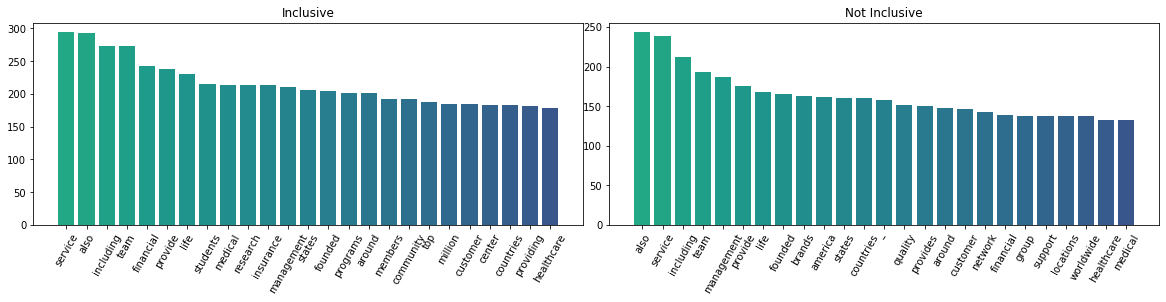

In [38]:
# Set the color of our bar graphs
color = cm.viridis_r(np.linspace(.4,.8, 30))

new_figure = plt.figure(figsize=(16,4))

# Define subplots
ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

# Generate a line plot on first axes
ax.bar(inclusive_bar_words, inclusive_bar_counts, color=color)
# ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(not_inclusive_bar_words, not_inclusive_bar_counts, color=color )

ax.title.set_text('Inclusive')
ax2.title.set_text('Not Inclusive')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60)

plt.tight_layout(pad=0)

# plt.savefig('word count bar graphs.png')

plt.show()

#### Visualization 
- Word Clouds

In [39]:
# Getting our data into a dictionary
# FORMAT:  dictionary = dict(zip(keys, values))
#!pip install wordcloud
from wordcloud import WordCloud
inclusive_dictionary = dict(zip(inclusive_bar_words, inclusive_bar_counts))
not_inclusive_dictionary = dict(zip(not_inclusive_bar_words, not_inclusive_bar_counts))

In [40]:
not_inclusive_dictionary

{'also': 243,
 'service': 238,
 'including': 212,
 'team': 193,
 'management': 187,
 'provide': 175,
 'life': 168,
 'founded': 165,
 'brands': 163,
 'america': 161,
 'states': 160,
 'countries': 160,
 '–': 158,
 'quality': 151,
 'provides': 150,
 'around': 148,
 'customer': 146,
 'network': 142,
 'financial': 139,
 'group': 138,
 'support': 138,
 'locations': 138,
 'worldwide': 137,
 'healthcare': 133,
 'medical': 132}

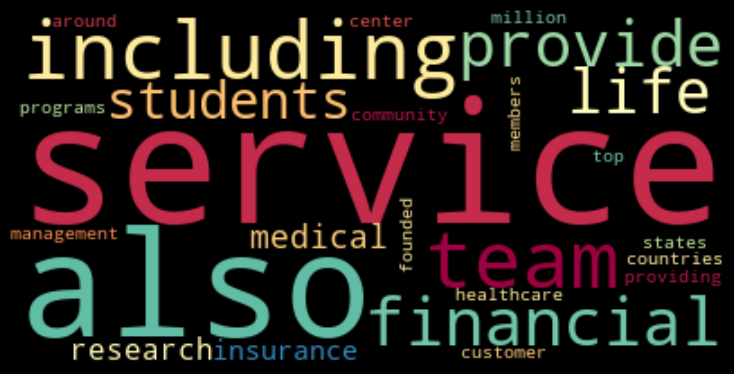

In [41]:
# Create the word cloud:

wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(inclusive_dictionary)

# Display the generated image w/ matplotlib:

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)

# Uncomment the next line if you want to save your image:
# plt.savefig('satire_wordcloud.png')

plt.show()

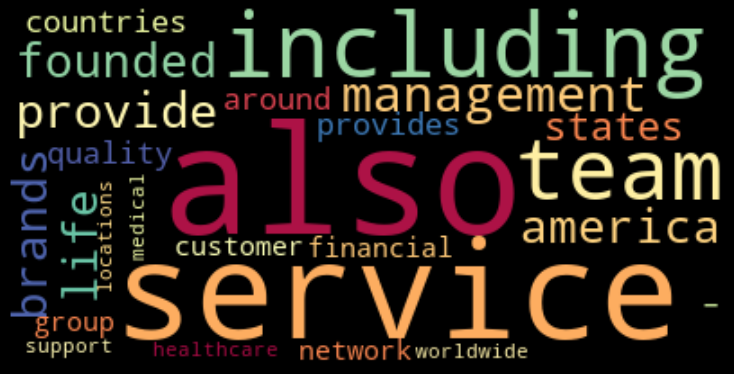

In [42]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(not_inclusive_dictionary)

plt.figure(figsize=(10,10), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
# plt.savefig('not_satire_wordcloud.png')

plt.show()

What about in ONLY inclusive/not inclusive companies?

In [43]:
def returnNotMatches(a, b):
    return [x for x in a if x not in b]

In [44]:
returnNotMatches(flat_incl, flat_not_incl)

['smalltomidsized',
 'topics',
 'mckinsey',
 'mckinsey',
 'alerts',
 'twofold',
 'substantial',
 'excites',
 'strongly',
 'ithaca',
 'doha',
 'qatar',
 'dude',
 'barbara',
 'ucsb',
 'ynez',
 'ucsb',
 'barbara',
 'manual',
 'winners',
 'winners',
 'uci',
 'uci',
 'edds',
 'uci',
 'isu',
 'whirlwind',
 'isu',
 'cyclones',
 'isu',
 'isu',
 'carver',
 'purdue',
 'purdue',
 'purdue',
 'purdue',
 'ut',
 'prosim',
 'commonwealth',
 'mathworks',
 'mathematical',
 'matlab',
 'algorithm',
 'visualization',
 'numeric',
 'computation',
 'simulink',
 'diagram',
 'modelbased',
 'multidomain',
 'biotechpharmaceutical',
 'matlab',
 'simulink',
 'mathworks',
 'natick',
 'computation',
 'visualization',
 'visitors',
 'seekers',
 'resumes',
 'comscore',
 'visitors',
 'adobe',
 'adobe',
 'spartan',
 'spartan',
 'msu',
 'msu',
 'dominates',
 'msu',
 'oncampus',
 'allopathic',
 'dvms',
 'corn',
 'topselling',
 'anticancer',
 'msu',
 'fiu',
 'fiu',
 'fiu',
 'expenditures',
 'fiu',
 'fiu',
 'fiu',
 'patricia'

## Prepping for modeling

In [49]:
##CORPUS:
#define features and target
data = df['CLEAN_DESCRIPTION'] 
target = df['TARGET']

In [50]:
# applying the above function to our data/features with map() method
processed_description = list(map(process_description, df.CLEAN_DESCRIPTION))

In [51]:
##Lemmatizer
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 

# creating a list with all lemmatized outputs
lemmatized_output = []

for listy in processed_description:
    lemmed = ' '.join([lemmatizer.lemmatize(w) for w in listy])
    lemmatized_output.append(lemmed)

In [52]:
#defining X_lem for modeling process
X_lem = lemmatized_output
# [' '.join(d) for d in processed_data]

y_lem = target
#X_lem[0] #Sanity Check

In [53]:
# Sanity Check
print(len(y_lem))
print(len(X_lem))

2225
2225


In [54]:
## Saving pickles for Modeling notebook

In [55]:
# Pickling X and y
pickle_out = open('modeling/X_lem.pkl','wb')
pickle.dump(X_lem, pickle_out)
pickle_out.close()

y_lem.to_pickle('modeling/y_lem.pkl')

In [56]:
## Pickling stopwords
pickle_out =  open('modeling/stopwords.pkl', 'wb')
pickle.dump(sw_list, pickle_out)
pickle_out.close()


**Train-Test Split:**

In [57]:
sw_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [58]:
# always train-test split THEN apply vectorizer 
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=42)

tfidf = TfidfVectorizer(stop_words=sw_list, #try sw_set?
                       ngram_range=(1,3)) ## TEST remove stopwords, turn into uppercase, bigram/trigram

#fit vectorizer to both training and testing set
tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)

### RF Notes

- **try also with BoW instead of TF-IDF??**
- **try also with Stemming instead of Lemmatization??** 

2/10 Results:
- Testing Accuracy: 0.5662
- Testing Precision: 0.5437
- Testing Recall: 0.4807
- F1 Score: 0.5103

### Baseline model 
Random Forest with Lemmatization, trigrams

2/16 Results:
- Testing Accuracy: 0.5775
- Testing Precision: 0.6083
- Testing Recall: 0.7461
- F1 Score: 0.6702

In [59]:
# TEST
rf_classifier_lem = RandomForestClassifier(n_estimators=120, random_state=42)


In [66]:
## Fit model to train set
rf_classifier_lem.fit(tfidf_data_train_lem, y_train_lem)

rf_train_preds_lem = rf_classifier_lem.predict(tfidf_data_train_lem)
rf_test_preds_lem = rf_classifier_lem.predict(tfidf_data_test_lem)

In [71]:
rf_acc_score_lem = accuracy_score(y_test_lem, rf_test_preds_lem)
rf_precision_score_lem = metrics.precision_score(y_test_lem, rf_test_preds_lem)
rf_recall_score_lem = metrics.recall_score(y_test_lem, rf_test_preds_lem)
rf_f1_score_lem = f1_score(y_test_lem, rf_test_preds_lem)

rf_train_accuracy = accuracy_score(y_train_lem, rf_train_preds_lem)


print('Random Forest with Lemmatization Features:\n')

print("Testing Accuracy: {:.4}".format(rf_acc_score_lem))
print("Testing Precision: {:.4}".format(rf_precision_score_lem))
print("Testing Recall: {:.4}".format(rf_recall_score_lem))
print("F1 Score: {:.4}".format(rf_f1_score_lem))

print("\nTraining Accuracy: {:.4}".format(rf_train_accuracy))
print('Null Accuracy is', round(y_test_lem.value_counts()[0]
                               /y_test_lem.value_counts().sum(), 4))

Random Forest with Lemmatization Features:

Testing Accuracy: 0.5775
Testing Precision: 0.6083
Testing Recall: 0.7461
F1 Score: 0.6702

Training Accuracy: 1.0
Null Accuracy is 0.4247


(2.0, 0.0)

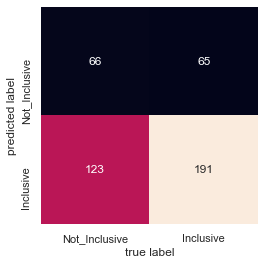

In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

mat = confusion_matrix(y_test_lem, rf_test_preds_lem)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Not_Inclusive', 'Inclusive'], 
            yticklabels=['Not_Inclusive', 'Inclusive']
           )
plt.xlabel('true label')
plt.ylabel('predicted label');

## Fixing cut-off bug
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

### Next model

Stretch:
- Sentiment analysis